<h1 align="center">UW CNC Fall Hackathon </h1>  
<h3 align="center"> Dec 4, 2024 </h3>   
<h3 align="center"> mapping mesoscale connectivity between the frontal cortex and thalamus</h3> 
    
    

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
**Overview:** In this notebook, we will analyze the connectivity between thalamic subregions and the frontal cortex using a 3D light sheet microscopy dataset of whole mouse brains. 
While this tutorial focuses on thalamocortical connectivity, the dataset contains connections between the frontal cortex and other brain regions, which have yet to be thoroughly explored. 
    
**Dataset:**  
    
**Experiment:** Retrograde viruses were injected into frontal cortex, inducing the expression of nuclear-localized fluorophores in host cells in frontal cortex and their presynaptic partners across the brain. Each brain received 1-3 viral injections in different locations in frontal cortex that express different fluorophores. As a result, each brain dataset is multiplexed and contains multiple image channels. Whole brains were imaged using a light sheet microscope (SmartSPIM). 
    
**Image Processing:** The image tiles were stitched together into a 3D volume then transformed into a reference brain template called the Common Coordinate Framework (CCF). Cells were automatically detected and subsequently run through a classifier to remove false positives, yielding spatial coordinates for detected cells. The spatial coordinates were then transformed into CCF space. *Note that the cell detection model was optimized for the thalamus. 

        
**Goal:** This tutorial will show you how to:  
    1. analyze connectivity across brain regions  
    2. work with 3D volumetric microscopy data of whole mouse brains 



<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Import packages and load data<br>
    
    

In [25]:
# general imports 

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize, ListedColormap

import pandas as pd
%matplotlib inline

In [2]:
# specific imports and brain atlas initialization 

from load_data import load_data
import brainglobe_atlasapi as atlasapi
from brainglobe_atlasapi import BrainGlobeAtlas
atlasapi.config.write_config_value('brainglobe_dir', '/data/.brainglobe') # points to allen mouse atlases pre-loaded in data folder 
atlas = BrainGlobeAtlas('allen_mouse_25um', 
                        check_latest = False) # load CCF mouse brain atlas, 25um resolution 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

### Break:  
we will start by importing metadata as a df and unpack some of the experimental information

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #f69cf7; ">
SdV: It might help to start with picking a brain - what do we know about this brain? Why are we picking it? This might work best starting with metadata, so we can add that shortly, but rather than brain out of a hat, let's motivate why we are looking at this brain.

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Load data for a single brain 
      
load_data will pull the relevant data from the /data folders for a given mouse ID.  

Here, you can see which channels went through each stage of processing.  
(raw image channels > cell detection model applied > transformation to CCF space)
    
(to do - write docstrings for load_data)


In [3]:
mouse_ID = '698035' 
x = load_data(mouse_ID)

Loading data from ../data/SmartSPIM_698035_2023-10-24_18-38-40_stitched_2023-10-28_20-52-51/image_tile_fusing/OMEZarr
Found the following channels: ['445', '488', '561', '639']
Found cell segmentations in the following channels: ['445', '488', '561']
Found CCF aligned quantifications in the following channels: ['445', '488', '561']
Grabbing volumes for level: 3


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

We can quickly look at the slices in each channel using the `plotSlice` function in load_data. 

In [5]:
help(x.plotSlice)

Help on method plotSlice in module load_data:

plotSlice(ch=[], plane='coronal', section=[], extent=[], level=3, ticks=True, printOutput=True) method of load_data.load_data instance
    Plots a single brain slice from the volumetric data in a specified plane.
    
    Parameters
    ----------
    ch : str, optional
        Imaging channel to plot (e.g., "488", "561"). If not specified, defaults to the shortest wavelength available.
    plane : str, optional
        Plane in which to view the slice: "coronal", "sagittal", or "transverse". Defaults to "coronal".
    section : int or float, optional
        Position along the selected plane, in microns, to slice. If not specified, defaults to the midpoint.
    extent : list of float, optional
        4-element list defining the [left, right, bottom, top] extent of the plot in microns.
        If not provided, defaults to the entire image field.
    level : int, optional
        Downsampling level for the data. Higher levels correspond to

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
Let's plot a slice in the coronal plane. If "section" is left blank, it will take us to the middle of the volume. 

Grabbing volumes for level: 3
Plotting coronal axis, section: 5128 (level 3 index: 641)


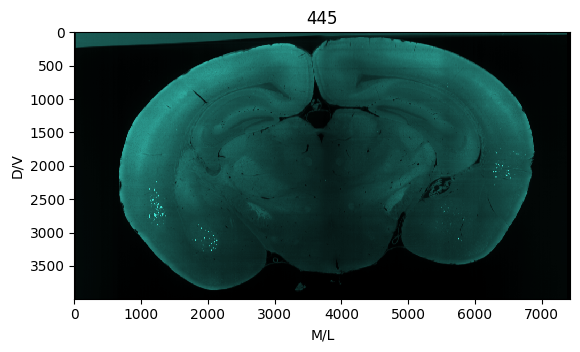

In [4]:
x.plotSlice(ch = "445", plane = "coronal", section = []) 

# note that these slices are not transformed to CCF 
# question about difference between the section and index output here 
# to do - attach units to the function (pixels) 


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
The orientVol function will reshape the data depending on the plane orientation. The shape of the reoriented volume can tell us the total number of sections.

In [5]:
[chVol, _, _, _] = x.orientVol(ch = "445", plane = "coronal", returnLabels = True)
chVol.shape[0]

1282

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #DFF0D8; ">

**Task 1:** Try plotting a different slice in a different plane (e.g. "sagittal")

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Plotting the data slice by slice in this manner can be slow. Alternatively, we can more readily explore the 3D volumetric anatomy dataset on neuroglancer. 

In [ ]:
# point to neuroglancer links in metadata/qc portal 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
**Automated Cell Detection**  
    
With this dataset, we can map which brain regions provide input to the frontal cortex. First, we need to quantify the number of targeted cells and their locations. One way to do this is by looking at each section and manually annotating the cells. This is laborious, especially at the whole brain scale. To aid in reducing manual classification, cells were automatically detected using neural network models. The rest of this tutorial will show you how to load and analyze the spatial coordinates of the detected cells. 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

The `getCellsCCFdf` function loads the spatial coordinates of the detected cells in a given channel. Note that these coordinates are transformed into CCF space. 

In [6]:
help(x.getCellsCCFdf)

Help on method getCellsCCFdf in module load_data:

getCellsCCFdf(ch: list) method of load_data.load_data instance
    Retrieves and formats CCF transformed coordinates of segmented cells into a dataframe. 
    
    Parameters
    ----------
    ch : list of str 
        List of imaging channels to retrieve coordinates from (e.g., ["488", "561"]). 
    
    Returns
    -------
    location_df : pd.DataFrame
        Dataframe where each row is a cell and each column is a coordinate: AP (anterior-posterior), DV (dorsal-ventral), or             ML (medial-lateral), with an additional "channel" column indicating the channel of origin.



In [7]:
cellLocs = x.getCellsCCFdf(["445", "488", "561"])
cellLocs

,AP,DV,ML,channel
0,248,17,259,445
1,259,15,196,445
2,252,15,202,445
3,250,18,194,445
4,241,19,202,445
...,...,...,...,...
536458,246,276,338,561
536459,256,282,335,561
536460,252,282,333,561
536461,250,279,339,561


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #DFF0D8; ">

**Task 2:** How many cells were detected in each channel? 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Let's explore where the targeted cells are located in the brain. Since this project is focused on mapping thalamocortical connections, we'll take a slice of the brain centered around the thalamus and look at a histogram of the cells targeted in that region. We'll plot in the coronal plane. Using the atlas.get_structure_mask function, we can also overlay the brain structure boundaries to help us identify where the cell targets are. 
    
You can play around with the `plane` and `window` parameters to adjust the location and thickness of the slice we plot or the roiList to outline different brain regions. 

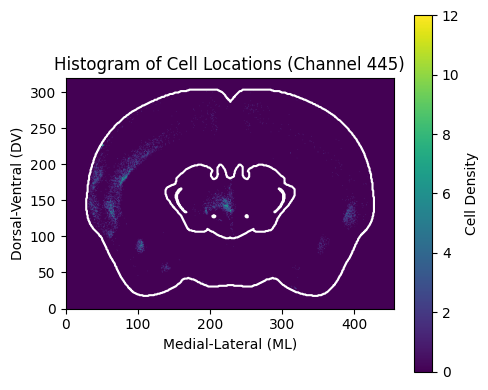

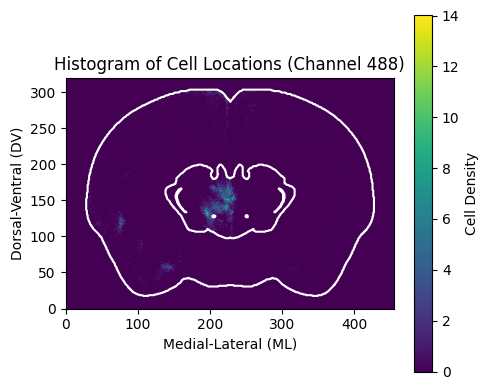

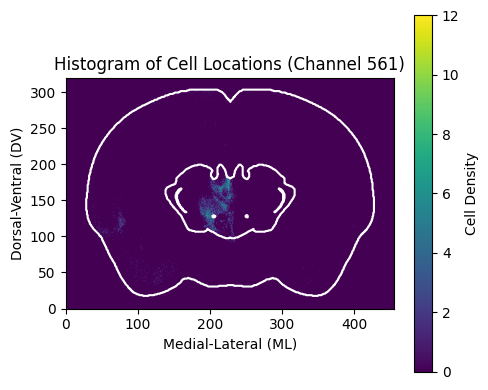

In [30]:
import matplotlib.pyplot as plt
import numpy as np

channel = ["445", "488", "561"]
plane = 250
window = 5
roiList = ["root", "TH"]

# Loop through each channel 
for ch in channel: 
    # Create a figure for each channel
    fig, ax = plt.subplots(figsize=(5, 4))

    # Generate contour outlines for brain structures
    for roi in roiList:
        roi_mask = atlas.get_structure_mask(roi)
        ax.contour(
            roi_mask[plane, :, :],
            levels=[0.5],
            colors="white",
            linewidths=1.5,
            origin="upper"
        )

    # Generate the histogram of cell coordinates
    planeLocs = cellLocs.loc[
        (cellLocs['AP'] >= plane - window) & (cellLocs['AP'] <= plane + window), :
    ]

    xbins = np.arange(0, atlas.get_structure_mask("root").shape[2], 1)
    ybins = np.arange(0, atlas.get_structure_mask("root").shape[1], 1)
    hist, xedges, yedges = np.histogram2d(
        planeLocs[planeLocs['channel'] == ch]["ML"],
        planeLocs[planeLocs['channel'] == ch]["DV"],
        bins=(xbins, ybins),
    )

    # Overlay the heatmap
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    heatmap = ax.imshow(
        hist.T,  # Transpose because imshow expects (rows, cols)
        extent=extent,
        origin="upper",
        cmap="viridis",
        alpha=1,
    )

    # Add colorbar and labels
    cbar = plt.colorbar(heatmap, ax=ax)
    cbar.set_label("Cell Count")
    ax.set_title(f"Histogram of Cell Locations (Channel {ch})")
    ax.set_xlabel("Medial-Lateral (ML)")
    ax.set_ylabel("Dorsal-Ventral (DV)")

    plt.tight_layout()
    plt.show()


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
Focusing on the thalamus, it looks like different injection sites within frontal cortex target different subregions of the thalamus.  

We can pass the coordinates through the `atlas.structure_from_coords` function to identify the brain region each cell is in to quantify differences in brain region targeting across different experimental parameters, such as injection site.     

In [9]:
help(atlas.structure_from_coords)

Help on method structure_from_coords in module brainglobe_atlasapi.core:

structure_from_coords(coords, microns=False, as_acronym=False, hierarchy_lev=None, key_error_string='Outside atlas') method of brainglobe_atlasapi.bg_atlas.BrainGlobeAtlas instance
    Get the structure from a coordinate triplet.
    
    Parameters
    ----------
    coords : tuple or list or numpy array
        Triplet of coordinates.
    microns : bool
        If true, coordinates are interpreted in microns.
    as_acronym : bool
        If true, the region acronym is returned.
        If outside atlas (structure gives key error),
        return "Outside atlas"
    hierarchy_lev : int or None
        If specified, return parent node at thi hierarchy level.
    
    Returns
    -------
    int or string
        Structure containing the coordinates.



In [31]:
brain_region = [] 

# iterate through each coordinate in the df, ignoring the index 
for _, cell in cellLocs.iterrows(): 
    # match the brain structure 
    brain_region.append(atlas.structure_from_coords([ cell['AP'], cell['DV'], cell['ML'] ], as_acronym = True)) 
    
cellLocs['brain_region'] = brain_region
cellLocs

,AP,DV,ML,channel,brain_region
0,248,17,259,445,RSPagl1
1,259,15,196,445,RSPagl1
2,252,15,202,445,Outside atlas
3,250,18,194,445,RSPagl1
4,241,19,202,445,MOs1
...,...,...,...,...,...
536458,246,276,338,561,OLF
536459,256,282,335,561,COAa
536460,252,282,333,561,COAa
536461,250,279,339,561,COAa


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

To help us assess the connectivity across brain regions, we can use this cellLocs dataframe to construct a connectivity matrix. First, let's filter our dataframe to cells within thalamic subregions. Then, we will use pivot_table to create a connectivity matrix where each row is a channel/injection site, each column is a brain region, and the values are cell counts. 

In [33]:
# thalamic subregions of interest 
roiList = ["MD", "PT", "IAD", "PVT", "IMD", "CM", "PCN", "CL"]

# filter the df for cells within the roiList 
filtered_cellLocs = cellLocs[cellLocs["brain_region"].isin(roiList)] 

# generate connectivity matrix: 
# rows = channels 
# columns = thalamus brain regions 
# values = cell counts 

conn_mat = filtered_cellLocs.pivot_table(index = "channel", 
                                      columns = "brain_region", 
                                      aggfunc = "size", 
                                      fill_value = 0)
conn_mat

brain_region,CL,CM,IAD,IMD,MD,PCN,PT,PVT
channel,,,,,,,,
445,57,1364,34,153,997,754,2,156
488,28,751,225,615,1526,11,259,1046
561,69,178,430,113,914,0,486,1891


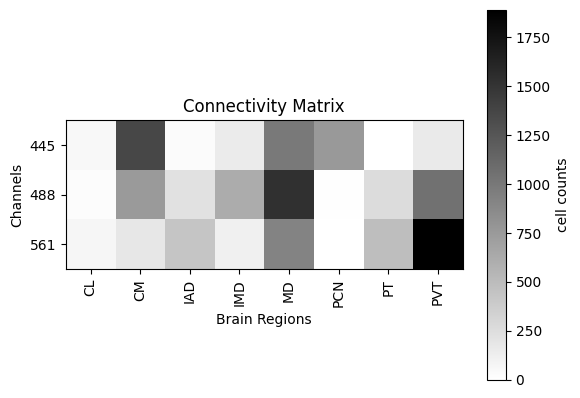

In [34]:
# plot the connectivity matrix as a heatmap 

plt.imshow(conn_mat, cmap="gray_r")
plt.colorbar(label="cell counts")
plt.xticks(ticks=range(len(conn_mat.columns)), labels=conn_mat.columns, rotation=90)
plt.yticks(ticks=range(len(conn_mat.index)), labels=conn_mat.index)
plt.title("Connectivity Matrix")
plt.xlabel("Brain Regions")
plt.ylabel("Channels")
plt.show()

In [ ]:
# to do - add follow up questions here 

In [32]:
# might remove following stuff below this cell

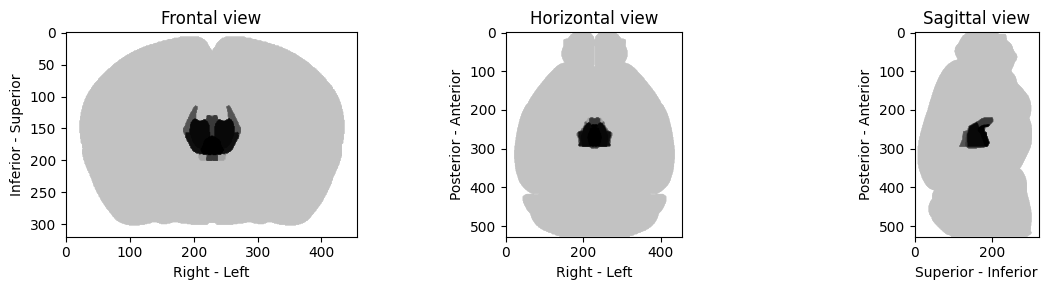

In [19]:
#maybe we don't need this 

from matplotlib.colors import LogNorm

# Generate and combine the masks
mask_combined = atlas.get_structure_mask("root")
mask_combined[mask_combined > 0] = 1  # Initialize root mask with base value (1)
channel = "445"

for i, roi in enumerate(roiList, start=2):
    roi_mask = atlas.get_structure_mask(roi)
    intensity = conn_mat.loc[channel, roi]
    roi_mask[roi_mask > 0] = intensity
    mask_combined += roi_mask

# Plot the results with LogNorm
space = atlas.space
f, axs = plt.subplots(1, 3, figsize=(12, 3))

for i, (plane, labels) in enumerate(zip(space.sections, space.axis_labels)):
    axs[i].imshow(
        mask_combined.max(i), 
        cmap="gray_r", 
        norm=LogNorm(vmin=0.1, vmax=mask_combined.max())  # Adjust vmin and vmax
    )
    axs[i].set_title(f"{plane.capitalize()} view")
    axs[i].set_ylabel(labels[0])
    axs[i].set_xlabel(labels[1])

plt.tight_layout()
plt.show()

In [17]:
roiList = ["MD", "PT", "IAD", "PVT", "IMD", "CM", "PCN", "CL"]

# Define the base mask as the root structure
mask_combined = atlas.get_structure_mask("root")
mask_combined[mask_combined > 0] = 1  # Initialize root mask with a base value (1)

# Assign unique values to each ROI and add them to the combined mask
for i, roi in enumerate(roiList, start = 2):  # Start at 2 to avoid overwriting the root
    roi_mask = atlas.get_structure_mask(roi)
    roi_mask[roi_mask > 0] = i  # Assign a unique value based on index
    mask_combined += roi_mask  # Combine the masks


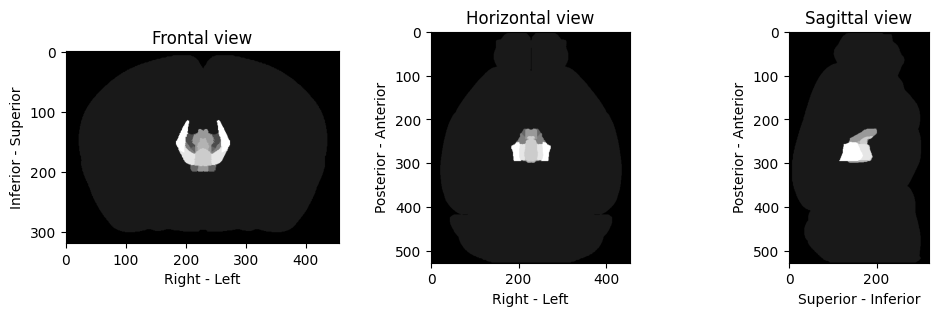

In [18]:
space = atlas.space
f, axs = plt.subplots(1,3, figsize=(12, 3))
for i, (plane, labels) in enumerate(zip(space.sections, space.axis_labels)):
    axs[i].imshow(mask_combined.max(i), cmap="gray")
    axs[i].set_title(f"{plane.capitalize()} view")
    axs[i].set_ylabel(labels[0])
    axs[i].set_xlabel(labels[1])


In [ ]:
# ccfCoordDict = {685903: {'445': [171, 66, 284], '488': [162, 61, 248], '561': [157, 80, 267]},
#                 698035: {'445': [115, 120, 287], '488': [100, 127, 236], '561': [133, 133, 232]},
#                 689238: {'445': [126, 92, 259], '488': [127, 84, 271], '561': [122, 138, 237]},
#                 691387: {'445': [94, 117, 279], '488': [103, 124, 295], '561': [103, 131, 314]},
#                 691388: {'445': [107, 126, 259], '488': [99, 130, 274], '561': [102, 112, 238]},
#                 694512: {'445': [142, 101, 237], '488': [154, 75, 254], '561': [157, 89, 238]},
#                 695721: {'445': [107, 98, 255], '488': [144, 85, 258], '561': [129, 89, 254]},
#                 696668: {'561': [161, 82, 241]},
#                 684812: {'445': [166, 65, 197], '488': [166, 70, 265], '561': [167, 85, 240]},
#                 684821: {'488': [119, 100, 266], '561': [121, 98, 298]},
#                 689237: {'445': [139, 96, 244], '561': [140, 86, 295]},
#                 696669: {'445': [141, 87, 289], '561': [105, 113, 287]},
#                 693977: {'488': [154, 93, 268], '561': [93, 139, 240]},
#                 698927: {'488': [104, 128, 295], '561': [95, 117, 245]},
#                 698928: {'488': [146, 138, 232], '561': [145, 88, 271]},
#                 693979: {'488': [164, 91, 239], '561': [154, 95, 264]},
#                 693980: {'488': [120, 139, 293], '561': [115, 101, 286]},
#                 692909: {'561': [122, 132, 294]},
#                 692907: {'561': [115, 112, 244]},
#                 692912: {'561': [152, 131, 245]},
#                 692911: {'561': [123, 127, 294]},
#                 701750: {'561': [150, 142, 243]},
#                 701751: {'561': [105, 126, 284]},
#                 701754: {'561': [146, 80, 255]},
#                 721832: {'488': [120, 145, 306]}} #manually annotated, estimate injection site later

# virusDict = {685903:'AAVrg-XFP',
#              # 698034:'AAVrg',
#              698035:'AAVrg-XFP',
#              689238:'AAVrg-XFP',
#              691387:'AAVrg-XFP',
#              691388:'AAVrg-XFP',
#              694512:'AAVrg-XFP',
#              695721:'AAVrg-XFP',
#              696668:'AAVrg-XFP',
#              684812:'AAVrg-XFP',
#              684821:'AAVrg-XFP',
#              689237:'AAVrg-XFP',
#              696669:'AAVrg-XFP',
#              693977:"RabV-XFP",
#              698927:"RabV-XFP",
#              698928:"RabV-XFP",
#              693979:"RabV-XFP",
#              693980:"RabV-XFP",
#              692909:"AAVrg-Recombinase",
#              692907:"AAVrg-Recombinase",
#              692912:"AAVrg-Recombinase",
#              692911:"AAVrg-Recombinase",
#              685110:"AAVrg-Recombinase",
#              701750:"RabV-Recombinase",
#              701751:"RabV-Recombinase",
#              701754:"RabV-Recombinase",
#              721832:"AAVrg-XFP"
#             }